## Imports

In [1]:
import bertFuncs as func
from functions import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics.pairwise import cosine_similarity
from transformers import logging
logging.set_verbosity_error()
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
from nltk.corpus import wordnet as wn

In [2]:
test = get_firm_embeddings("amazon", "works", 111, "all")

## 1. Get Embeddings

### 1.1 Get Firm Embeddings

In [276]:
# Read S&P500 company names.
# Source: https://github.com/datasets/s-and-p-500-companies/blob/master/data/constituents.csv

company_names = pd.read_csv("sp500.csv")
#company_names["Count"] = company_names['Name'].str.split().apply(len)
#company_names.rename(columns = {"cleanedname":"Name"}, inplace = True)

In [328]:
# Get embeddings for S&P 500 names. Average embeddings are calculated for multi-word firms. 
# Stored for faster import later. 

context = "works"

for company in tqdm(company_names["Name"]):
    name_list = company.split(" ")
    
    # Get contextual embedding for each part of the name.  
    embeddings = pd.DataFrame()
    for name in name_list: 
        embeddings[[f"{name}_male", f"{name}_female", "tuple"]] = get_firm_embeddings(name, context, 111, "all")[["Value 1", "Value 2", "tuple"]]
    
    # Take average of different name parts. 
    embeddings["average_male"] = embeddings.loc[:, embeddings.columns.str.endswith('_male')].mean(axis=1)
    embeddings["average_female"] = embeddings.loc[:, embeddings.columns.str.endswith('_female')].mean(axis=1)
    
    # Calculate delta / bias. 
    embeddings["female-male"] = embeddings["average_female"] - embeddings["average_male"]
    
    # Store for faster import later. 
    embeddings.to_csv(f"./averaged_embeddings/{company}.csv")

  0%|          | 0/1 [00:00<?, ?it/s]

### 1.1 Get Random Noun Embeddings

In [326]:
# Load and clean list of english nouns and generate random sample.

nouns = pd.read_csv('nouns.csv', sep=";")
nouns = nouns[nouns['nouns'].str.strip().str.split(' ').str.len().eq(1)] # Only considering single word nouns.
nouns_sample = nouns["nouns"].sample(n = 500, random_state = 42)
nouns_sample = list(nouns_sample)

# Make sure no overlap between nouns and companies 
company_names["Name_Lower"] = company_names['Name'].str.lower()
nouns_sample = [x for x in nouns_sample if x not in list(company_names["Name_Lower"])]

In [280]:
# Get embeddings for random nouns. 
# Stored for faster import later. 

context = "works"

for noun in tqdm(nouns_sample):
    comparison = get_firm_embeddings(noun, context, 111, "all")
    comparison.to_csv(f"./averaged_embeddings/{noun}.csv")

  0%|          | 0/500 [00:00<?, ?it/s]

## 2. Initial analysis

In [329]:
# Get all considered dimensions. 

dimensions = get_firm_embeddings("amazon", "works", 111, "all")

all_dimensions = dimensions["tuple"]

In [282]:
len(all_dimensions)

101

### 2.1 Distribution Plots

In [ ]:
def get_dimension_distribution(considered_companies, antonym_pair, nouns_sample): 
    
    result = pd.DataFrame()
    result["companies"] = considered_companies
    result["value_male"] = 0
    result["value_female"] = 0
    result["difference"] = 0

    for company in considered_companies: 
        

        comparison = pd.read_csv(f"./averaged_embeddings/{company}.csv")
        comparison = comparison.groupby("tuple", as_index = False).mean() # Account for duplicates. 

        value_male = float(comparison[comparison["tuple"] == antonym_pair]["average_male"])

        value_female = float(comparison[comparison["tuple"] == antonym_pair]["average_female"])
        difference = value_female - value_male

        result["value_male"].loc[result["companies"] == company] = value_male
        result["value_female"].loc[result["companies"] == company] = value_female
        result["difference"].loc[result["companies"] == company] = difference

    rand_result = pd.DataFrame()
    rand_result["nouns"] = nouns_sample
    rand_result["rand_value_male"] = 0
    rand_result["rand_value_female"] = 0
    rand_result["rand_difference"] = 0
    
    for noun in nouns_sample: 
        rand_comparison = pd.read_csv(f"./averaged_embeddings/{noun}.csv")
        #rand_comparison["tuple"] = list(zip(rand_comparison["0"], rand_comparison["1"]))
        rand_comparison = rand_comparison.groupby("tuple", as_index = False).mean() # Account for duplicates. 
        rand_value_male = float(rand_comparison[rand_comparison["tuple"] == antonym_pair]["Value 1"])
        rand_value_female = float(rand_comparison[rand_comparison["tuple"] == antonym_pair]["Value 2"])
        rand_difference = rand_value_female - rand_value_male
        
        rand_result["rand_value_male"].loc[rand_result["nouns"] == noun] = rand_value_male
        rand_result["rand_value_female"].loc[rand_result["nouns"] == noun] = rand_value_female
        rand_result["rand_difference"].loc[rand_result["nouns"] == noun] = rand_difference
    
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 6))
    
    gs = GridSpec(2, 1, figure=fig)
    fig.suptitle(f"Distributions for {str(antonym_pair)}", weight="bold")

    # Plot male and female distribution 
    stat, p_value = ttest_ind(result["value_male"], result["value_female"])
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title(f"Male vs. Female Firm Distribution ({check_significance(p_value)}, p-value = {round(p_value, 5)})", fontsize=9)
    sns.distplot(result["value_male"], ax = ax1, label = "Male Context", color = '#3AA8F3')
    sns.distplot(result["value_female"], ax = ax1, label = "Female Context", color = 'fuchsia')
    plt.axvline(0, color = "black", ls = "--")
    plt.axvline(result["value_male"].mean(), color = "#3AA8F3")
    plt.axvline(result["value_female"].mean(), color = "fuchsia")
    plt.legend() 
    
    # Plot difference
    stat, p_value = ttest_ind(result["difference"], rand_result["rand_difference"])
    ax4 = fig.add_subplot(gs[1, :])
    ax4.set_title(f"Corporate vs. Random Difference ({check_significance(p_value)}, p-value = {round(p_value, 5)})", fontsize=9)
    sns.distplot(result["difference"], ax = ax4, label = "Firm difference", color = "cyan")
    sns.distplot(rand_result["rand_difference"], ax = ax4, label = "random difference", color = "grey")
    plt.axvline(0, color = "black", ls = "--")
    plt.axvline(rand_result["rand_difference"].mean(), color = "grey")
    plt.axvline(result["difference"].mean(), color = "cyan")
    plt.legend()
    
    plt.savefig(f'{antonym_pair}.png', bbox_inches = "tight")

In [ ]:
def get_dimension_pvalues(considered_companies, antonym_pair, nouns_sample): 
    
    result = pd.DataFrame()
    result["companies"] = considered_companies
    result["value_male"] = 0
    result["value_female"] = 0
    result["difference"] = 0

    for company in considered_companies: 
        comparison = pd.read_csv(f"./averaged_embeddings/{company}.csv")
        #comparison["tuple"] = list(zip(comparison["0"], comparison["1"]))
        comparison = comparison.groupby("tuple", as_index = False).mean() # Account for duplicates. 
        
        value_male = float(comparison[comparison["tuple"] == antonym_pair]["average_male"])
        value_female = float(comparison[comparison["tuple"] == antonym_pair]["average_female"])
        difference = value_female - value_male
        
        result["value_male"].loc[result["companies"] == company] = value_male
        result["value_female"].loc[result["companies"] == company] = value_female
        result["difference"].loc[result["companies"] == company] = difference
    
    rand_result = pd.DataFrame()
    rand_result["nouns"] = nouns_sample
    rand_result["rand_value_male"] = 0
    rand_result["rand_value_female"] = 0
    rand_result["rand_difference"] = 0
    
    for noun in nouns_sample: 
        rand_comparison = pd.read_csv(f"./averaged_embeddings/{noun}.csv")
        #rand_comparison["tuple"] = list(zip(rand_comparison["0"], rand_comparison["1"]))
        rand_comparison = rand_comparison.groupby("tuple", as_index = False).mean() # Account for duplicates. 
        rand_value_male = float(rand_comparison[rand_comparison["tuple"] == antonym_pair]["Value 1"])
        rand_value_female = float(rand_comparison[rand_comparison["tuple"] == antonym_pair]["Value 2"])
        rand_difference = rand_value_female - rand_value_male
        
        rand_result["rand_value_male"].loc[rand_result["nouns"] == noun] = rand_value_male
        rand_result["rand_value_female"].loc[rand_result["nouns"] == noun] = rand_value_female
        rand_result["rand_difference"].loc[rand_result["nouns"] == noun] = rand_difference
    
    stat1, p_value1 = ttest_ind(result["value_male"], result["value_female"])
    stat2, p_value2 = ttest_ind(result["difference"], rand_result["rand_difference"])
    
    res1 = round(p_value1, 5)
    res2 = round(p_value2, 5)
    
    return [res1, res2]

In [445]:
def get_dimension_distribution(considered_companies, antonym_pair, nouns_sample): 
    
    result = read_embedding_values(considered_companies, antonym_pair)
    rand_result = read_embedding_values(nouns_sample, antonym_pair)
    

    fig = plt.figure(constrained_layout=True, figsize=(12, 6))
    
    gs = GridSpec(2, 1, figure=fig)
    fig.suptitle(f"Distributions for {str(antonym_pair)}", weight="bold")

    # Plot male and female distribution 
    stat, p_value = ttest_ind(result["value_male"], result["value_female"])
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title(f"Male vs. Female Firm Distribution ({check_significance(p_value)}, p-value = {round(p_value, 5)})", fontsize=9)
    sns.distplot(result["value_male"], ax = ax1, label = "Male Context", color = '#3AA8F3')
    sns.distplot(result["value_female"], ax = ax1, label = "Female Context", color = 'fuchsia')
    plt.axvline(0, color = "black", ls = "--")
    plt.axvline(result["value_male"].mean(), color = "#3AA8F3")
    plt.axvline(result["value_female"].mean(), color = "fuchsia")
    plt.legend() 
    
    # Plot difference
    stat, p_value = ttest_ind(result["difference"], rand_result["rand_difference"])
    ax4 = fig.add_subplot(gs[1, :])
    ax4.set_title(f"Corporate vs. Random Difference ({check_significance(p_value)}, p-value = {round(p_value, 5)})", fontsize=9)
    sns.distplot(result["difference"], ax = ax4, label = "Firm difference", color = "cyan")
    sns.distplot(rand_result["rand_difference"], ax = ax4, label = "random difference", color = "grey")
    plt.axvline(0, color = "black", ls = "--")
    plt.axvline(rand_result["rand_difference"].mean(), color = "grey")
    plt.axvline(result["difference"].mean(), color = "cyan")
    plt.legend()
    
    plt.savefig(f'{antonym_pair}.png', bbox_inches = "tight")

In [444]:
def read_embedding_values(embedding_names, antonym_pair): 
    
    result = pd.DataFrame()
    result["companies"] = embedding_names
    result["value_male"] = 0
    result["value_female"] = 0
    result["difference"] = 0

    for embedding in embedding_names: 
        comparison = pd.read_csv(f"./averaged_embeddings/{embedding}.csv")

        comparison = comparison.groupby("tuple", as_index = False).mean() # Account for duplicates.         
        value_male = float(comparison[comparison["tuple"] == antonym_pair]["average_male"])
        value_female = float(comparison[comparison["tuple"] == antonym_pair]["average_female"])
        difference = value_female - value_male
        result["value_male"].loc[result["companies"] == company] = value_male
        result["value_female"].loc[result["companies"] == company] = value_female
        result["difference"].loc[result["companies"] == company] = difference
    
    return result    

In [446]:
# Create plots for all 8 dimensions. 

for dimension in all_dimensions: 
    get_dimension_distribution(company_names["Name"], str(dimension), nouns_sample)

KeyError: 'average_male'

### 2.2 P-Values

In [392]:
considered_companies = company_names["Name"].unique()

In [374]:
# also tested for single-word company names 
#considered_companies = company_names[company_names["Count"] == 1]["Name"]

res_all = defaultdict()

for dimension in tqdm(all_dimensions): 
    res = get_dimension_pvalues(considered_companies, str(dimension), nouns_sample)
    res_all[dimension] = res
    
res_all_df = pd.DataFrame(res_all).transpose()
res_all_df.rename(columns = {0:"Male vs. Female Corporate Embedding", 1:"Male Firm vs. Male Random", 
                         2:"Female Firm vs. Female Random", 3:"Difference Firm vs. Difference Random",
                        4:"Male vs. Female Random Embedding"}, 
              inplace = True)

  0%|          | 0/111 [00:00<?, ?it/s]

In [375]:
# Show all p-values. 

res_all_df

,,Male vs. Female Corporate Embedding,Male Firm vs. Male Random,Female Firm vs. Female Random,Difference Firm vs. Difference Random,Male vs. Female Random Embedding
confident,shy,0.46729,0.00000,0.00000,0.02167,0.70568
open,distant,0.17615,0.00000,0.00000,0.00175,0.00027
creative,uncreative,0.34979,0.71484,0.51188,0.00008,0.70763
aggressive,submissive,0.63803,0.00000,0.00000,0.10382,0.92587
sincere,insincere,0.51510,0.00000,0.00000,0.00000,0.82049
...,...,...,...,...,...,...
tolerant,intolerant,0.76308,0.00000,0.00000,0.00007,0.20267
resilient,nonresilient,0.51331,0.00004,0.00000,0.04054,0.02387
funny,boring,0.00816,0.00032,0.00052,0.78369,0.00034
able,clumsy,0.09915,0.00000,0.00000,0.72608,0.02124


In [388]:
# Filter p-values. 

sign_level = 0.05

res_all_df_filtered = res_all_df.loc[
                    (res_all_df["Male vs. Female Corporate Embedding"] < sign_level) 
                    #& (res_all_df["Male Firm vs. Male Random"] < sign_level) 
                    #& (res_all_df["Female Firm vs. Female Random"] < sign_level) 
                     #(res_all_df["Difference Firm vs. Difference Random"] < sign_level) 
                    #& (res_all_df["Male vs. Female Random Embedding"] < sign_level) 
                    ]

In [389]:
len(res_all_df_filtered)

18

In [338]:
dimensions_df

,tuple,average
75,"(confident, shy)",0
8,"(open, distant)",0
62,"(creative, uncreative)",0
94,"(aggressive, submissive)",0
27,"(sincere, insincere)",0
...,...,...
30,"(honest, dishonest)",0
19,"(funny, boring)",0
58,"(able, clumsy)",0
54,"(smart, stupid)",0


In [390]:
# Get dimension average to see if it favours male or female

dimensions_df = pd.DataFrame(all_dimensions)
dimensions_df["average"] = 0

for dimension in tqdm(all_dimensions): 
    
    company_res = []
    
    for company in considered_companies: 
        comparison = pd.read_csv(f"./averaged_embeddings/{company}.csv")
        comparison = comparison.groupby("tuple", as_index = False).mean()
        company_res.append(float(comparison[comparison["tuple"] == str(dimension)]["female-male"]))
        
    dimensions_df["average"].loc[dimensions_df["tuple"] == dimension] = (sum(company_res) / len(company_res))*100

  0%|          | 0/111 [00:00<?, ?it/s]

In [391]:
len(dimensions_df[dimensions_df["average"] >0]) / len(dimensions_df)

0.6486486486486487

### Get Values for Company

In [393]:
# Read and prepare dictionaries. 

dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries["tuple"] = list(zip(dictionaries["Term1"].astype(str), dictionaries["Term2"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)

In [412]:
company_names["Ability"] = 0
company_names["Agency"] = 0
company_names["Morality"] = 0
company_names["Politics"] = 0
company_names["Sociability"] = 0
company_names["Status"] = 0

for name in tqdm(company_names["Name"]):
    comparison = pd.read_csv(f"./averaged_embeddings/{name}.csv", index_col = 0)
    comparison = comparison.sort_index()
    comparison = pd.concat([comparison, dictionaries], axis=1) 
    
    comparison = comparison.groupby("Dictionary", as_index = True).mean()
    comparison = comparison.transpose()
    comparison = comparison.iloc[-1:]
    
    company_names["Ability"].loc[company_names["Name"] == name] = float(comparison["Ability"])
    company_names["Agency"].loc[company_names["Name"] == name] = float(comparison["Agency"])
    company_names["Morality"].loc[company_names["Name"] == name] = float(comparison["Morality"])
    company_names["Politics"].loc[company_names["Name"] == name] = float(comparison["Politics"])
    company_names["Sociability"].loc[company_names["Name"] == name] = float(comparison["Sociability"])
    company_names["Status"].loc[company_names["Name"] == name] = float(comparison["Status"])
    

company_names.to_csv("041122_gender_biases_results_v1.csv")

  0%|          | 0/505 [00:00<?, ?it/s]

In [405]:
nouns = pd.DataFrame(nouns_sample).rename(columns = {0:"Name"})

In [408]:
nouns = pd.DataFrame(nouns_sample).rename(columns = {0:"Name"})

nouns["Ability"] = 0
nouns["Agency"] = 0
nouns["Morality"] = 0
nouns["Politics"] = 0
nouns["Sociability"] = 0
nouns["Status"] = 0

for name in tqdm(nouns_sample):
    comparison = pd.read_csv(f"./averaged_embeddings/{name}.csv", index_col = 0)
    comparison = comparison.sort_index()
    comparison = pd.concat([comparison, dictionaries], axis=1) 
    
    comparison = comparison.groupby("Dictionary", as_index = True).mean()
    comparison = comparison.transpose()
    comparison = comparison.iloc[-1:]
    
    nouns["Ability"].loc[nouns["Name"] == name] = float(comparison["Ability"])
    nouns["Agency"].loc[nouns["Name"] == name] = float(comparison["Agency"])
    nouns["Morality"].loc[nouns["Name"] == name] = float(comparison["Morality"])
    nouns["Politics"].loc[nouns["Name"] == name] = float(comparison["Politics"])
    nouns["Sociability"].loc[nouns["Name"] == name] = float(comparison["Sociability"])
    nouns["Status"].loc[nouns["Name"] == name] = float(comparison["Status"])
    


  0%|          | 0/499 [00:00<?, ?it/s]

In [409]:
nouns

,Name,Ability,Agency,Morality,Politics,Sociability,Status
0,solution,-0.090357,-0.029000,-0.042225,0.129782,-0.033643,-0.030341
1,cancer,0.010701,-0.016409,0.022930,0.056731,0.008393,0.019863
2,example,-0.246358,-0.044295,-0.105618,0.168893,-0.152824,-0.070918
3,stopwatch,-0.094973,-0.080667,-0.080657,0.012849,-0.097793,0.042927
4,sparerib,-0.056609,-0.023163,-0.022589,0.131126,-0.040100,-0.063857
...,...,...,...,...,...,...,...
494,lion,-0.067541,-0.061056,0.005211,0.028581,-0.031119,0.010869
495,quantity,-0.115656,-0.136533,-0.003656,0.012055,-0.103291,-0.051888
496,saxophone,-0.057382,-0.026515,0.010485,0.023334,0.009261,0.115998
497,basketball,0.013045,-0.041934,0.003194,0.054072,-0.008607,0.185398


In [ ]:
from scipy.stats import ttest_ind

In [411]:
dictionaries["Dictionary"].unique()

array(['Sociability', 'Morality', 'Ability', 'Agency', 'Status',
       'Politics'], dtype=object)

In [416]:
def check_significance(p_value): 
    if p_value < 0.05: 
        stat_res = "Significant Difference"
    else: 
        stat_res = "No Significant Difference"
        
    return stat_res

In [417]:
dictionary_comparison_results = {}

for dictionary in dictionaries["Dictionary"].unique(): 
    stat, p_value = ttest_ind(company_names[dictionary], nouns[dictionary])
    sign = check_significance(p_value)
    dictionary_comparison_results[dictionary] = [p_value, sign]

In [418]:
dictionary_comparison_results

{'Sociability': [1.7542309017501916e-08, 'Significant Difference'],
 'Morality': [0.000715323341723173, 'Significant Difference'],
 'Ability': [4.025130446503094e-15, 'Significant Difference'],
 'Agency': [0.0030512677772062233, 'Significant Difference'],
 'Status': [0.8717194895530588, 'No Significant Difference'],
 'Politics': [0.2175867107228613, 'No Significant Difference']}

### 2.3 Average over all dimensions

In [363]:
# Get delta for selected antonyms between male and female vector. 

company_names["Selected_Mean_Delta"] = 0

for name in tqdm(company_names["Name"].unique()):
    comparison = pd.read_csv(f"./averaged_embeddings/{name}.csv")
    company_names["Selected_Mean_Delta"].loc[company_names["Name"] == name] = (comparison["female-male"].mean())*10000

  0%|          | 0/505 [00:00<?, ?it/s]

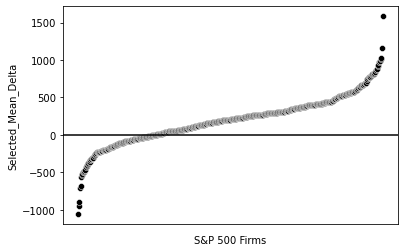

In [364]:
# Plot difference between selected dimensions for firms. 

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

g1 = sns.scatterplot(data = company_names.sort_values(by=["Selected_Mean_Delta"], ascending=True), x = "Name", y = "Selected_Mean_Delta", color = "black", ax = ax)
g1.set(xticklabels=[]) 
g1.set(xlabel="S&P 500 Firms") 
g1.axhline(0, color = "black")
g1.tick_params(bottom=False)  

In [365]:
len(company_names[company_names["Selected_Mean_Delta"] > 0])/len(company_names)

0.7465346534653465

In [366]:
company_names[company_names["Selected_Mean_Delta"] == company_names["Selected_Mean_Delta"].max()]

,Symbol,Name,Sector,Name_Lower,Selected_Mean_Delta
499,XYL,Xylem,Industrials,xylem,1584.96573


In [367]:
# Analyze companies with highest difference meaning highest bias toward female embedding. 

company_names.sort_values(by=["Selected_Mean_Delta"], ascending=False).head(10).reset_index(drop = True)

,Symbol,Name,Sector,Name_Lower,Selected_Mean_Delta
0,XYL,Xylem,Industrials,xylem,1584.965730
1,INTU,Intuit,Information Technology,intuit,1158.537293
2,NUE,Nucor,Materials,nucor,1030.015237
3,ADI,Analog Devices,Information Technology,analog devices,1009.555233
4,AMAT,Applied Materials,Information Technology,applied materials,993.592642
5,WM,Waste Management,Industrials,waste management,991.190863
6,AIZ,Assurant,Financials,assurant,978.845559
7,ALLE,Allegion,Industrials,allegion,934.488695
8,INTC,Intel,Information Technology,intel,921.404741
9,SYK,Stryker Corporation,Health Care,stryker corporation,876.317985


<AxesSubplot:xlabel='Selected_Mean_Delta', ylabel='Sector'>

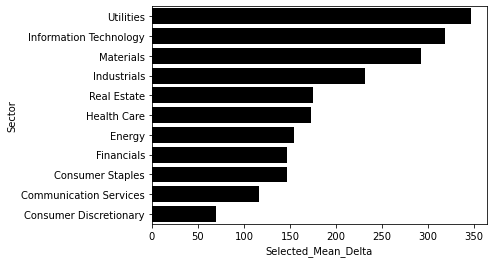

In [368]:
# Check for difference between sectors. 

sp_500_groupedby_industry = company_names.groupby("Sector").mean().sort_values(by=["Selected_Mean_Delta"], 
                                                                        ascending=False)
sns.barplot(data = sp_500_groupedby_industry, y = sp_500_groupedby_industry.index, 
            x= "Selected_Mean_Delta", color = "black")